## **Integer Program for Strategic Sensing Grid**

**Sets**  
- $ N $: Set of network nodes (potential camera locations)  
- $ C $: Set of grid cells representing danger areas  
- $ N_c \subseteq N $: Nodes that can cover cell $ c \in C $  

**Parameters**  
- $ w_c $: Priority weight for grid cell $ c \in C $  
- $ K $: Maximum number of sensors

**Decision Variables**  
- $ y_i \in \{0,1\} $: 1 if camera placed at node $ i \in N $, 0 otherwise  
- $ z_c \in \{0,1\} $: 1 if cell $ c \in C $ is covered, 0 otherwise  

**Objective Function**  
  
  Maximize total weighted coverage of high-danger areas:

  $\quad \quad \max \displaystyle\sum_{c \in C} w_c z_c$

**Constraints**  

1. **Camera Capacity**  

    $\displaystyle\sum_{i \in N} y_i \leq K$
  

2. **Coverage Activation**:
  
    $\displaystyle\sum_{i \in N_c} y_i \geq z_c \quad \forall c \in C$
   

    *Ensures coverage is only counted if at least one camera is placed in visible nodes*

3. **Camera Implication**:  

    $y_i \leq z_c \quad \forall c \in C, \quad \forall i \in N_c$
  
    *If a camera is placed at node $ i $, it must cover all cells $ c $ that $ i $ can observe*`

4. **Binary Requirements**  


    $y_i \in \{0,1\} \quad \forall i \in N \\
    z_c \in \{0,1\} \quad \forall c \in C$

**Key Properties**  
- **Bi-directional Coverage Relationship**: Constraints 2-3 create equivalence between:  
  $ z_c = 1 \iff \exists i \in N_c $ where $ y_i = 1 $  
- **Weighted Prioritization**: Objective function prioritizes coverage of cells with higher $ w_c $ values  
- **Sparse Placement**: Camera capacity constraint enforces strategic resource allocation


/var/folders/88/2d1b1n6j1z3_5sc443sl04900000gn/T/ipykernel_13702/3202012783.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  back_bay_gdf.unary_union,


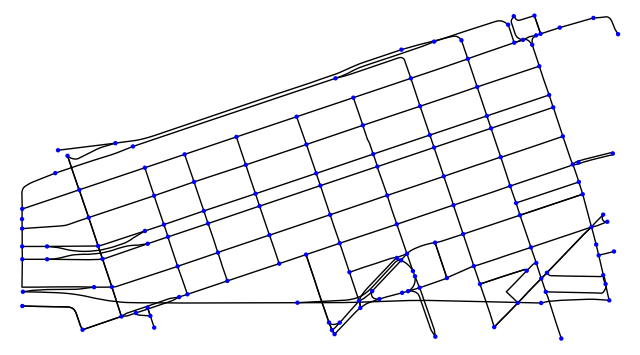

In [59]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from random import randint

# Define bounding box coordinates for Back Bay
north, south = 42.3561, 42.3468
east, west = -71.069, -71.0917

# Create GeoDataFrame with bounding box geometry
bbox = box(west, south, east, north)
back_bay_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

# Fetch street network within specified polygon
G = ox.graph_from_polygon(
    back_bay_gdf.unary_union, 
    network_type="drive",
    simplify=True
)

# Project graph to UTM coordinates
G_proj = ox.project_graph(G)

# Create consolidated grid network with 5m tolerance
G_grid = ox.consolidate_intersections(
    G_proj,
    tolerance=5,  # 5 meters in UTM projection
    rebuild_graph=True,
    dead_ends=False
)

fig, ax = ox.plot_graph(
    G_grid, 
    node_size=10,
    edge_linewidth=1,
    bgcolor='white',  # or '#FFFFFF'
    edge_color='black',  # or '#000000'
    node_color='blue',  # or '#000000'
    show=False,
    close=False
)



<Axes: >

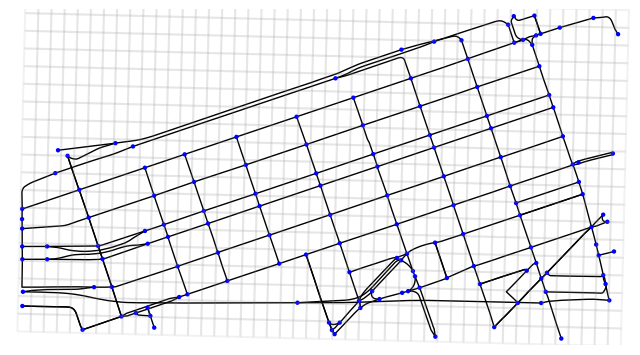

In [60]:
from shapely.geometry import Polygon
import numpy as np

# Convert the existing bounding box coordinates to a bbox tuple
bbox_tuple = (north, south, east, west)

# Create a grid of cells using OSMnx's grid creation utility

# Create grid cells with a 50m spacing
x_range = np.arange(west, east, 0.0005)  # approximate for 50m spacing
y_range = np.arange(south, north, 0.0005)  # approximate for 50m spacing

# Create a list of polygons for the grid cells
grid_geometries = []
for x in x_range:
    for y in y_range:
        cell = Polygon([
            (x, y),
            (x + 0.0005, y),
            (x + 0.0005, y + 0.0005),
            (x, y + 0.0005),
            (x, y)
        ])
        grid_geometries.append(cell)

# Create GeoDataFrame with the grid cells
grid_cells = gpd.GeoDataFrame(
    geometry=grid_geometries,
    crs=back_bay_gdf.crs
).to_crs(G_grid.graph['crs'])

# Get node GeoDataFrame with geometries from the graph
nodes_gdf = ox.graph_to_gdfs(G_grid, edges=False)

# Calculate coverage relationships
coverage_matrix = {}
for cell_id, cell in enumerate(grid_cells.geometry):
    coverage_matrix[cell_id] = []
    for node_id, node_row in nodes_gdf.iterrows():
        if node_row.geometry.distance(cell) <= 50:  # 50m coverage radius
            coverage_matrix[cell_id].append(node_id)

# plot the grid cells and G_grid
fig, ax = ox.plot_graph(
    G_grid, 
    node_size=10,
    edge_linewidth=1,
    bgcolor='white',  # or '#FFFFFF'
    edge_color='black',  # or '#000000'
    node_color='blue',  # or '#000000'
    show=False,
    close=False
)
# Plot grid cells
grid_cells.boundary.plot(ax=ax, color='grey', alpha=0.1)

In [61]:
new_df = pd.read_csv('Boston_Crime_Data_2022.csv')

new_df['geometry'] = new_df[['Lat', 'Long']].apply(
    lambda x: Point(x['Long'], x['Lat']), axis=1
)

# Create a GeoDataFrame
points_gdf = gpd.GeoDataFrame(new_df, geometry='geometry', crs="EPSG:4326")

# Transform to UTM Zone 19N to match your grid cells
points_gdf = points_gdf.to_crs("EPSG:32619")

# Perform spatial join all at once (more efficient than looping)
join_result = gpd.sjoin(points_gdf, grid_cells, how='left', predicate='within')

# Create a column to indicate if points are inside the grid
points_gdf['in_grid'] = ~join_result['index_right'].isna()

# Now you can access the grid cell information for points inside the grid
points_gdf['grid_cell_id'] = join_result['index_right']


/var/folders/88/2d1b1n6j1z3_5sc443sl04900000gn/T/ipykernel_13702/3993509278.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv('Boston_Crime_Data_2022.csv')


### **Get the unconstrained sensor coverage**

In [62]:
# Create danger weights dictionary (example values)
danger_weights = {
    cell_id: randint(0,10)  # Your custom function
    for cell_id in list(grid_cells.index)
}

<Axes: >

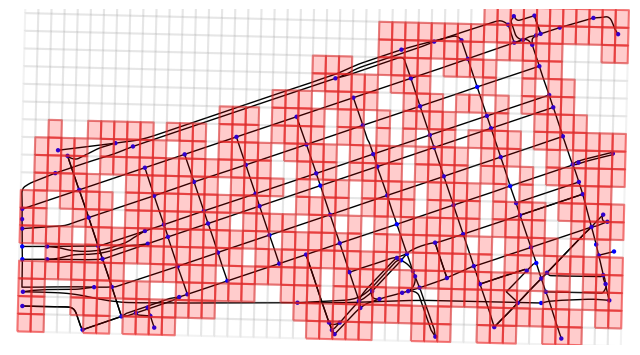

In [63]:
from gurobipy import Model, GRB, quicksum
N = 500
m = Model("MarathonSurveillance")
# set output flag to 0 to suppress Gurobi output
m.setParam('OutputFlag', 0)
# Use optimized node set
nodes = list(G_grid.nodes)

y = m.addVars(nodes, vtype=GRB.BINARY, name="Sensors")

# Coverage variables tied to grid cells
z = m.addVars(len(grid_cells), vtype=GRB.BINARY, name="Coverage")

# Add an objective function (minimizing total units while considering danger weighting)
m.setObjective(
    quicksum(z[grid_id] * danger_weights[grid_id] for grid_id in list(grid_cells.index)),
    GRB.MAXIMIZE)

# Coverage constraints
for cell_id, node_ids in coverage_matrix.items():
    m.addConstr(
        quicksum(y[node_id] for node_id in node_ids) >= z[cell_id],
        name=f"Coverage_{cell_id}"
    )

# Set time limit and optimize
m.setParam('TimeLimit', 300)  # 5-minute time limit
m.optimize()

# get unconstrained solution
selected_cells = [cell_id for cell_id in range(len(grid_cells)) if z[cell_id].x > 0.5]
# Create a new GeoDataFrame for the selected grid cells
unconstrained_cells = grid_cells.iloc[selected_cells].copy()
# plot selected nodes
fig, ax = ox.plot_graph(
    G_grid, 
    node_size=10,
    edge_linewidth=1,
    bgcolor='white',  # or '#FFFFFF'
    edge_color='black',  # or '#000000'
    node_color='blue',  # or '#000000'
    show=False,
    close=False
)
# Plot grid cells
unconstrained_cells.boundary.plot(ax=ax, color='red', alpha=0.5)
unconstrained_cells.plot(ax=ax, color='red', alpha=0.2)
# Plot the points
grid_cells.boundary.plot(ax=ax, color='grey', markersize=5, alpha=0.1)



## **Create constrained solution using historical crime data**

In [64]:
# Define crime levels
crime_levels = {
    1: [
        "LARCENY SHOPLIFTING", "TOWED MOTOR VEHICLE", "INVESTIGATE PERSON", "INVESTIGATE PROPERTY",
        "SICK ASSIST", "SICK ASSIST - DRUG RELATED ILLNESS", "PROPERTY - LOST", "PROPERTY - FOUND",
        "LICENSE PREMISE VIOLATION", "VERBAL DISPUTE", "TRESPASSING", "FIRE REPORT", "FIRE REPORT/ALARM - FALSE",
        "LANDLORD - TENANT", "EVADING FARE", "GRAFFITI", "DISTURBING THE PEACE/ DISORDERLY CONDUCT/ GATHERING CAUSING ANNOYANCE/ NOISY PAR",
        "DANGEROUS OR HAZARDOUS CONDITION"
    ],
    3: [
        "LARCENY THEFT FROM BUILDING", "LARCENY ALL OTHERS", "LARCENY THEFT FROM MV - NON-ACCESSORY",
        "LARCENY THEFT OF BICYCLE", "LARCENY PICK-POCKET", "LARCENY PURSE SNATCH - NO FORCE",
        "VANDALISM", "FRAUD - CREDIT CARD / ATM FRAUD", "FRAUD - FALSE PRETENSE / SCHEME", "FRAUD - WIRE",
        "BURGLARY - COMMERCIAL", "BURGLARY - RESIDENTIAL", "AUTO THEFT", "AUTO THEFT - LEASED/RENTED VEHICLE",
        "AUTO THEFT - MOTORCYCLE / SCOOTER", "FORGERY / COUNTERFEITING", "STOLEN PROPERTY - BUYING / RECEIVING / POSSESSING",
        "THREATS TO DO BODILY HARM", "HARASSMENT/ CRIMINAL HARASSMENT", "FIREARM/WEAPON - FOUND OR CONFISCATED",
        "BALLISTICS EVIDENCE/FOUND", "RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUTSIDE BOSTON)",
        "RECOVERED - MV RECOVERED IN BOSTON (STOLEN IN BOSTON) MUST BE SUPPLEMENTAL",
        "M/V ACCIDENT - OTHER", "M/V ACCIDENT - PROPERTY DAMAGE", "M/V ACCIDENT - INVOLVING PEDESTRIAN - INJURY",
        "M/V ACCIDENT - INVOLVING BICYCLE - NO INJURY", "M/V ACCIDENT - INVOLVING BICYCLE - INJURY",
        "M/V ACCIDENT - INVOLVING PEDESTRIAN - NO INJURY", "M/V ACCIDENT - POLICE VEHICLE",
        "M/V ACCIDENT - OTHER CITY VEHICLE"
    ],
    7: [
        "ASSAULT - SIMPLE", "ASSAULT - AGGRAVATED", "ROBBERY", "ARSON", "ANIMAL ABUSE",
        "BOMB THREAT", "OPERATING UNDER THE INFLUENCE (OUI) ALCOHOL", "OPERATING UNDER THE INFLUENCE (OUI) DRUGS",
        "INTIMIDATING WITNESS", "SUICIDE / SUICIDE ATTEMPT", "DEATH INVESTIGATION",
        "WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TRAFFICKING/ OTHER",
        "M/V - LEAVING SCENE - PERSONAL INJURY", "WARRANT ARREST - BOSTON WARRANT (MUST BE SUPPLEMENTAL)",
        "WARRANT ARREST - OUTSIDE OF BOSTON WARRANT"
    ]
}

# Create a 'crime_level' column with default value of 1
points_gdf['crime_level'] = 1

# Update crime levels based on offense descriptions
for level, offenses in crime_levels.items():
    points_gdf.loc[points_gdf['OFFENSE_DESCRIPTION'].isin(offenses), 'crime_level'] = level

In [65]:
new_df = points_gdf[points_gdf['in_grid'] == True][['grid_cell_id','crime_level']]

grid_score = new_df.groupby('grid_cell_id')['crime_level'].sum().sort_values(ascending=False)

# make a dictionary for all grid cells that corresponds to their count in grid_score
grid_score_dict = {}
for i in range(len(grid_cells)):
    grid_score_dict[i] = 0
for i in grid_score.index:
    grid_score_dict[i] = grid_score[i]

In [66]:
# create function calculate_danger_score
def calculate_danger_score(cell_id):
    return grid_score_dict[cell_id] # Placeholder for actual danger score calculation

In [67]:
# Create danger weights dictionary (example values)
danger_weights = {
    cell_id: calculate_danger_score(cell_id)  # Your custom function
    for cell_id in list(grid_cells.index)
}

Optimization status: 2
Objective value: 1737.0
Number of surveillance units placed: 10
Placed at nodes: [29, 52, 58, 64, 79, 88, 106, 120, 122, 135]
Number of covered cells: 82
Coverage percentage: 9.38%


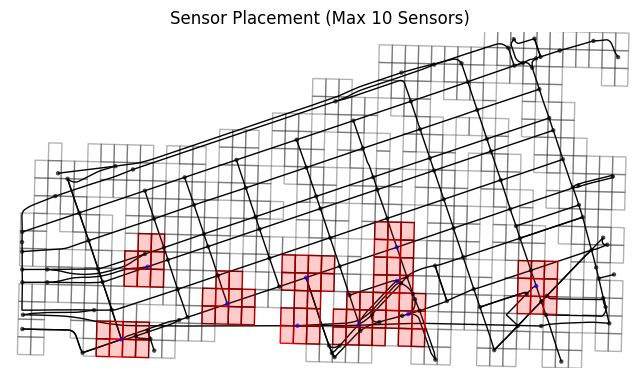

In [83]:
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

# Create optimization model
m = Model("MarathonSurveillance")
m.setParam('OutputFlag', 0)  # Suppress Gurobi output

# Set maximum number of surveillance cameras
MAX_CAMERAS = 10  # Change this value as needed

# Use optimized node set
nodes = list(G_grid.nodes)
y = m.addVars(nodes, name="Sensor")

# Coverage variables tied to grid cells
z = m.addVars(len(grid_cells), name="Coverage")

# constraint y and z between 0 and 1
for node in nodes:
    y[node].lb = 0
    y[node].ub = 1
for cell_id in range(len(grid_cells)):
    z[cell_id].lb = 0
    z[cell_id].ub = 1



# Objective: Maximize coverage of high-danger areas
m.setObjective(
    quicksum(z[grid_id] * danger_weights[grid_id] for grid_id in list(grid_cells.index)),
    GRB.MAXIMIZE)

# Camera capacity constraint: Cannot exceed MAX_CAMERAS units
m.addConstr(
    quicksum(y[node] for node in nodes) <= MAX_CAMERAS,
    name="CameraCapacity"
)

# Coverage constraints: A cell is covered only if at least one camera that can see it is placed
for cell_id, node_ids in coverage_matrix.items():
    m.addConstr(
        quicksum(y[node_id] for node_id in node_ids) >= z[cell_id],
        name=f"Coverage_{cell_id}"
    )

for cell_id, node_ids in coverage_matrix.items():
    for node_id in node_ids:
        m.addConstr(
            y[node_id] <= z[cell_id],
            name=f"Node_Coverage_{cell_id}_{node_id}"
        )
# relax integrality
# relax = m.relax()
# Set time limit and optimize
m.setParam('TimeLimit', 300)  # 5-minute time limit
m.optimize()

# Output optimization results
print(f"Optimization status: {m.status}")
if m.status == GRB.OPTIMAL or m.status == GRB.TIME_LIMIT:
    print(f"Objective value: {m.objVal}")
    print(f"Number of surveillance units placed: {sum(y[n].x > 0.5 for n in nodes)}")
    
    # Get placed surveillance units
    placed_units = [node for node in nodes if y[node].x > 0.5]
    print(f"Placed at nodes: {placed_units[:10]}..." if len(placed_units) > 10 else f"Placed at nodes: {placed_units}")
    
    # Get covered cells
    covered_cells = [cell_id for cell_id in range(len(grid_cells)) if z[cell_id].x > 0.5]
    print(f"Number of covered cells: {len(covered_cells)}")
    print(f"Coverage percentage: {len(covered_cells)/len(grid_cells)*100:.2f}%")
    
    # Plot the results
    fig, ax = ox.plot_graph(
        G_grid,
        node_color=['blue' if node in placed_units else 'black' for node in G_grid.nodes],
        node_zorder=3,
        node_alpha= 0.7,
        edge_linewidth=1,
        edge_alpha= 1,
        node_size=10,
        bgcolor='white',
        edge_color='black',
        show=False,
        close=False
    )

    # Plot the grid cells that are covered
    covered_cells_geom = grid_cells.iloc[covered_cells].geometry
    covered_cells_geom.boundary.plot(ax=ax, color='red',linewidth=1)
    # shade the covered cells
    covered_cells_geom.plot(ax=ax, color='red', alpha=0.2)
    unconstrained_cells.boundary.plot(ax=ax, color='black', alpha=0.3, linewidth=1)
    plt.title(f"Sensor Placement (Max {MAX_CAMERAS} Sensors)")
    plt.show()
else:
    print(f"Optimization failed with status: {m.status}")
